In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class GLU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GLU, self).__init__()
        self.linear_gate = nn.Linear(input_dim, output_dim)  
        self.linear_feature = nn.Linear(input_dim, output_dim)  

    def forward(self, eta2):
        gate = torch.sigmoid(self.linear_gate(eta2)) 
        feature = self.linear_feature(eta2)           
        eta3 = gate * feature   

        return eta3

class GRN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GRN, self).__init__()
        self.input_dim = input_dim

        self.linear_a = nn.Linear(input_dim, hidden_dim)

        self.linear_eta2 = nn.Linear(hidden_dim, hidden_dim)
        self.glu = GLU(hidden_dim, input_dim)
        # if input_dim > 1:
        #     self.layer_norm = nn.LayerNorm(input_dim)
        # else:
        #     self.layer_norm = nn.Identity()

    def forward(self, a, c=None):
        if c is None:
            c = torch.zeros_like(a)

        eta1 = F.elu(self.linear_a(a))
        eta2 = self.linear_eta2(eta1)
        eta3 = self.glu(eta2)

        residual = a + eta3
        # output = self.layer_norm(residual)
        output = residual

        
        return output

class VariableSelectionNetwork(nn.Module):
    def __init__(self, num_vars, d_model, hidden_dim):
        super(VariableSelectionNetwork, self).__init__()
        self.num_vars = num_vars
        self.d_model = d_model
        
        self.selection_grn = GRN(input_dim=num_vars * d_model, hidden_dim=hidden_dim)

        # Shared GRN for processing each variable (weights shared across all variables)
        self.variable_grn = GRN(input_dim=d_model, hidden_dim=hidden_dim)

    def forward(self, xi_t, context=None):
        """
        xi_t: Tensor of shape (batch_size, num_vars, d_model)
        context: Tensor of shape (batch_size, context_dim), or None
        """
        B, m_x, d_model = xi_t.shape
        assert m_x == self.num_vars and d_model == self.d_model

        # ----- Variable selection weights -----
        # Flatten xi_t across variables: shape -> (B, m_x * d_model)
        xi_flat = xi_t.view(B, -1)
        

        # Compute raw selection logits and apply softmax
        selection_logits = self.selection_grn(xi_flat, context)  # shape: (B, m_x * d_model)
        v_weights = F.softmax(selection_logits.view(B, m_x), dim=-1)  # (B, m_x)
        # ----- Processed feature vectors -----
        # xi_reshaped = xi_t.view(B * m_x, d_model)
        xi_reshaped = xi_t.reshape(B * m_x, d_model)

        xi_proc = self.variable_grn(xi_reshaped)  # (B * m_x, d_model)
        xi_proc = xi_proc.view(B, m_x, d_model)

        # print("xi_proc", xi_proc)

        # ----- Weighted sum -----
        v_weights = v_weights.unsqueeze(-1)  # (B, m_x, 1)

        # print("v_weights", v_weights)

        output = torch.sum(v_weights * xi_proc, dim=1)  # (B, d_model)

        return output, v_weights

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model):
        super(SingleHeadAttention, self).__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        Q = self.query(x)  # (B, T, d_model)
        K = self.key(x)    # (B, T, d_model)
        V = self.value(x)  # (B, T, d_model)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)  # (B, T, T)
        attn_weights = self.softmax(scores)                                 # (B, T, T)
        attn_output = torch.matmul(attn_weights, V)                         # (B, T, d_model)

        return attn_output, attn_weights

class MyModel(nn.Module):
    def __init__(self, num_vars_k, num_vars_T, d_model=1, hidden_dim=2, lstm_hidden=1):
        super(MyModel, self).__init__()
        self.vsn_k = VariableSelectionNetwork(num_vars=num_vars_k, d_model=d_model, hidden_dim=hidden_dim)
        self.vsn_T = VariableSelectionNetwork(num_vars=num_vars_T, d_model=d_model, hidden_dim=hidden_dim)

        self.lstm_cell = nn.LSTMCell(input_size=1, hidden_size=lstm_hidden)
        self.glu1 = GLU(input_dim=1, output_dim=1)
        self.grn1 = GRN(input_dim=1, hidden_dim=1)
        self.attn = SingleHeadAttention(d_model=1)
        self.grn2 = GRN(input_dim=1, hidden_dim=1)
        self.glu2 = GLU(input_dim=1, output_dim=1)

    def forward(self, x_k, x_T):
        """
        x_k: Tensor of shape (B, k, num_vars_k)
        x_T: Tensor of shape (B, T, num_vars_T)
        """

        B, k, num_vars_k = x_k.shape
        _, T, num_vars_T = x_T.shape

        vsn_outputs = []

        # Process first k steps
        for t in range(k):
            xi = x_k[:, t, :].view(B, num_vars_k, 1)
            out, _ = self.vsn_k(xi)
            vsn_outputs.append(out)
        # print("k", k)
        # print("vsn_outputs", vsn_outputs)

        # Process last T steps
        for t in range(T):
            xi = x_T[:, t, :].view(B, num_vars_T, 1)
            out, _ = self.vsn_T(xi)
            vsn_outputs.append(out)

        vsn_seq = torch.stack(vsn_outputs, dim=1)  # (B, k + T, 1)

        # print("vsn_outputs", vsn_outputs)
        # print("vsn_seq", vsn_seq)

        # LSTMCell
        h_t = torch.zeros(B, 1)
        c_t = torch.zeros(B, 1)
        lstm_outs = []

        for t in range(k + T):
            x_t = vsn_seq[:, t, :]
            h_t, c_t = self.lstm_cell(x_t, (h_t, c_t))
            lstm_outs.append(h_t)

        lstm_seq = torch.stack(lstm_outs, dim=1)  # (B, k + T, 1)

        # print("lstm_seq", lstm_seq)
        # Residual GLU + VSN
        combined1 = self.glu1(lstm_seq) + vsn_seq

        # GRN
        grn_out = self.grn1(combined1)

        # print("grn_out", grn_out)
        # Attention
        attn_out, _ = self.attn(grn_out)
 
        # print("attn_out", attn_out)
        # Residual GLU + GRN
        combined2 = self.glu1(attn_out) + grn_out

        # Final GRN + GLU
        grn_out2 = self.grn2(combined2)
        final = self.glu2(grn_out2) + combined1

        # print("final", final)

        # Return only the last T time steps
        return final[:, -T:, :]  # (B, T, 1)

In [ ]:
# --- Define quantile loss ---
def quantile_loss(y_pred, y_true, q=0.5):
    error = y_true - y_pred
    return torch.max((q - 1) * error, q * error).mean()

# --- Load data ---
df = pd.read_csv("AXISBANK.csv")
# cols = ['Open', 'High', 'Low', 'Last']
cols = ['Open', 'High', 'Low', 'Prev Close', 'Last', 'VWAP']
target_col = 'Close'


# Convert to tensor
full_X = torch.tensor(df[cols].values, dtype=torch.float32)
full_y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(-1)


# --- Hyperparameters ---
k = 2   # Number of past steps
T = 2   # Number of future steps
q = 0.5  # Quantile for loss
learning_rate = 0.1
num_epochs = 100
epoch_losses = []

# --- Initialize your quantum model ---
model = MyModel(num_vars_k=6, num_vars_T=6)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0.0
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]

        x_k = window[:k].unsqueeze(0)
        # x_T = window[k:k+T, 0].view(1, T, 1)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # print(total_loss)
    epoch_losses.append(total_loss)

    # print(loss)
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")


Epoch 1 - Loss: 4.7037
[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.91607093811035, 26.16607093811035, 26.16607093811035, 25.16607093811035, 25.16607093811035, 25.66607093811035, 25.66607093811035, 23.9660701751709, 23.9660701751709, 23.66607093811035, 23.66607093811035, 23.66607093811035, 23.66607093811035, 23.366071701049805, 23.366071701049805, 24.316070556640625, 24.316070556640625, 25.66607093811035, 25.66607093811035, 25.16607093811035, 25.16607093811035, 25

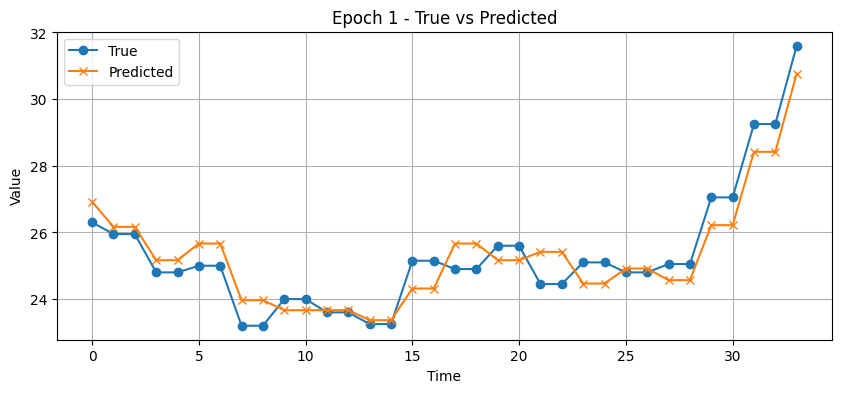

Epoch 15 - Loss: 4.8160
[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.845794677734375, 26.095794677734375, 26.095794677734375, 25.095794677734375, 25.095794677734375, 25.595794677734375, 25.595794677734375, 23.895793914794922, 23.895793914794922, 23.595794677734375, 23.595794677734375, 23.595794677734375, 23.595794677734375, 23.295795440673828, 23.295795440673828, 24.24579429626465, 24.24579429626465, 25.595794677734375, 25.595794677734375, 25.095794677734375, 25.0

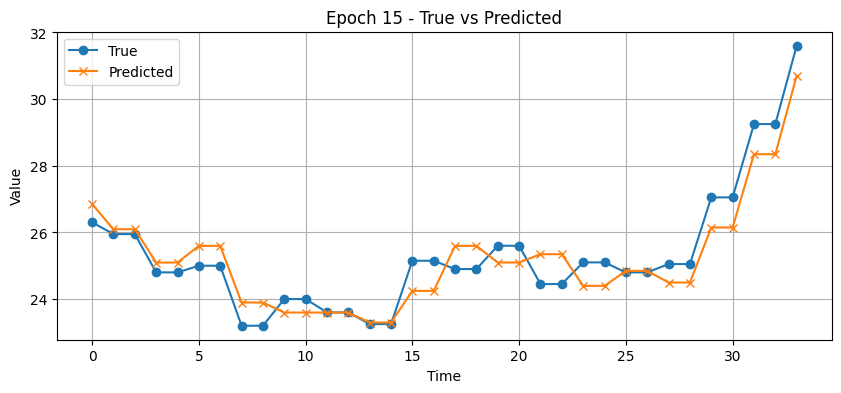

Epoch 30 - Loss: 4.7981
[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.867414474487305, 26.117414474487305, 26.117414474487305, 25.117414474487305, 25.117414474487305, 25.617414474487305, 25.617414474487305, 23.91741371154785, 23.91741371154785, 23.617414474487305, 23.617414474487305, 23.617414474487305, 23.617414474487305, 23.317415237426758, 23.317415237426758, 24.267414093017578, 24.267414093017578, 25.617414474487305, 25.617414474487305, 25.117414474487305, 25.1

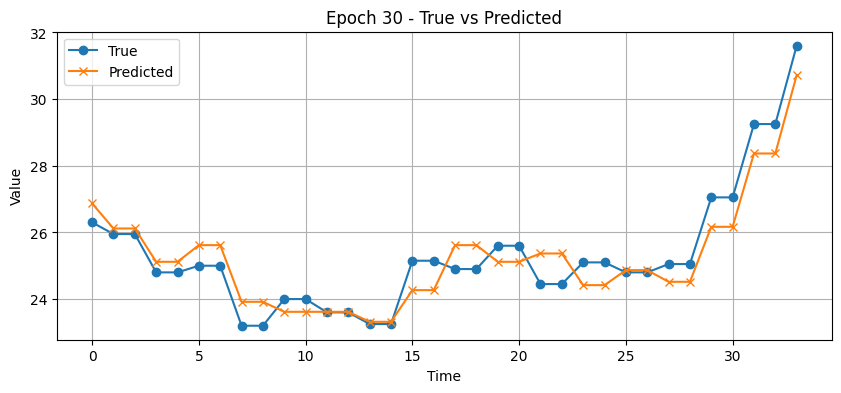

Epoch 100 - Loss: 4.8049
[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.907564163208008, 26.157564163208008, 26.157564163208008, 25.157564163208008, 25.157564163208008, 25.657564163208008, 25.657564163208008, 23.957563400268555, 23.957563400268555, 23.657564163208008, 23.657564163208008, 23.657564163208008, 23.657564163208008, 23.35756492614746, 23.35756492614746, 24.30756378173828, 24.30756378173828, 25.657564163208008, 25.657564163208008, 25.157564163208008, 25.15

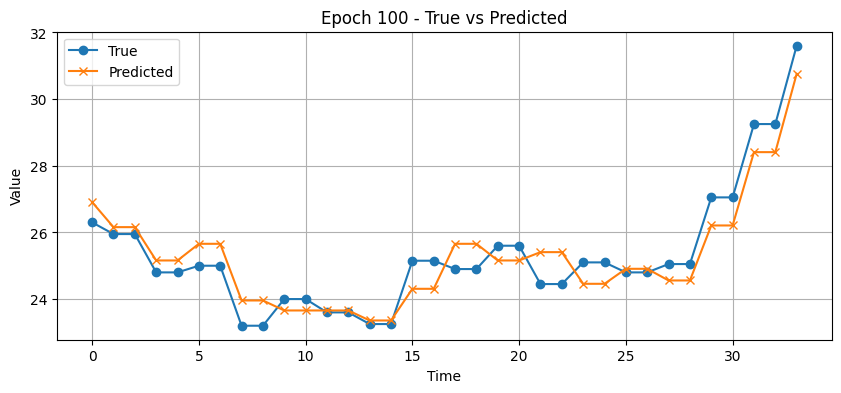

In [ ]:

# --- Define quantile loss ---
def quantile_loss(y_pred, y_true, q=0.5):
    error = y_true - y_pred
    return torch.max((q - 1) * error, q * error).mean()

# --- Load data ---
df = pd.read_csv("AXISBANK.csv")
cols = ['Open', 'High', 'Low', 'Prev Close', 'Last', 'VWAP']
target_col = 'Close'

# Convert to tensor
full_X = torch.tensor(df[cols].values, dtype=torch.float32)
full_y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(-1)

# --- Hyperparameters ---
k = 2   # Number of past steps
T = 2   # Number of future steps
q = 0.5  # Quantile for loss
learning_rate = 0.1
epoch_losses = []

# --- Visualization Helpers ---
def run_prediction(model, full_X, full_y, k, T):
    true_vals = []
    pred_vals = []
    model.eval()
    with torch.no_grad():
        for i in range(20 - (k + T) + 1):
            window = full_X[i:i+k+T]
            window_y = full_y[i:i+k+T]

            x_k = window[:k].unsqueeze(0)
            x_T = window[k:k+T].unsqueeze(0)
            y_T = window_y[k:k+T].unsqueeze(0)

            y_pred = model(x_k, x_T)
            # true_vals.extend(y_T.squeeze(-1).cpu().numpy())
            # pred_vals.extend(y_pred.squeeze(-1).cpu().numpy())
            true_vals.extend(y_T.squeeze().tolist())
            pred_vals.extend(y_pred.squeeze().tolist())
    return true_vals, pred_vals
 
def plot_predictions(epoch, true_vals, pred_vals):
    print(true_vals)
    print(pred_vals)
    plt.figure(figsize=(10, 4))
    plt.plot(true_vals, label='True', marker='o')
    plt.plot(pred_vals, label='Predicted', marker='x')
    plt.title(f"Epoch {epoch} - True vs Predicted")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Initialize your model ---
model = MyModel(num_vars_k=6, num_vars_T=6)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# === Stage 1: Epoch 0 to 15 ===
for epoch in range(0, 16):
    total_loss = 0.0
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]
        x_k = window[:k].unsqueeze(0)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_losses.append(total_loss)
    if epoch == 0 or epoch == 15:
        print(f"Epoch {epoch} - Loss: {total_loss:.4f}")
        true_vals, pred_vals = run_prediction(model, full_X, full_y, k, T)
        plot_predictions(epoch, true_vals, pred_vals)

# === Stage 2: Epoch 16 to 30 ===
for epoch in range(16, 31):
    total_loss = 0.0
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]
        x_k = window[:k].unsqueeze(0)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_losses.append(total_loss)
    if epoch == 30:
        print(f"Epoch {epoch} - Loss: {total_loss:.4f}")
        true_vals, pred_vals = run_prediction(model, full_X, full_y, k, T)
        plot_predictions(epoch, true_vals, pred_vals)

# === Stage 3: Epoch 31 to 100 ===
for epoch in range(31, 101):
    total_loss = 0.0
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]
        x_k = window[:k].unsqueeze(0)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_losses.append(total_loss)
    if epoch == 100:
        print(f"Epoch {epoch} - Loss: {total_loss:.4f}")
        true_vals, pred_vals = run_prediction(model, full_X, full_y, k, T)
        plot_predictions(epoch, true_vals, pred_vals)


In [25]:
# Save model weights only
torch.save(model.state_dict(), "trained_model.pth")

# Save losses as a Python pickle file
import pickle
with open("epoch_losses.pkl", "wb") as f:
    pickle.dump(epoch_losses, f)


In [53]:
# Reinitialize the model structure
model = MyModel(num_vars_k=4, num_vars_T=4)

# Load model weights
model.load_state_dict(torch.load("trained_model.pth"))
model.eval()  # or model.train() if continuing training

# Load losses
import pickle
with open("epoch_losses.pkl", "rb") as f:
    epoch_losses = pickle.load(f)


[9.161436080932617, 7.207069396972656, 4.956055164337158, 5.038845539093018, 4.996583461761475, 4.980082988739014, 5.004107475280762, 4.960165977478027, 5.359270095825195, 4.910433292388916, 4.899941921234131, 5.032714366912842, 5.005336284637451, 4.564659595489502, 5.096315383911133, 5.085684299468994, 4.877832889556885, 5.066482067108154, 4.917731285095215, 5.023671627044678, 4.998227119445801, 4.625833988189697, 4.94356632232666, 5.252756118774414, 5.119686603546143, 4.806312084197998, 4.999327659606934, 5.296051979064941, 4.860052108764648, 4.976824760437012, 4.702857971191406, 5.05821418762207, 4.66446590423584, 4.922759532928467, 5.316331386566162, 4.582251071929932, 4.98257303237915, 5.01602840423584, 5.313950061798096, 4.857069492340088, 4.968907833099365, 4.695046424865723, 5.056216239929199, 4.714295387268066, 5.053745746612549, 4.656649589538574, 4.917806148529053, 5.31164026260376, 4.6590189933776855, 4.929831027984619, 5.315188407897949, 4.38918399810791, 5.097573757171631

C:\Users\91876\AppData\Local\Temp\ipykernel_8156\40952148.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


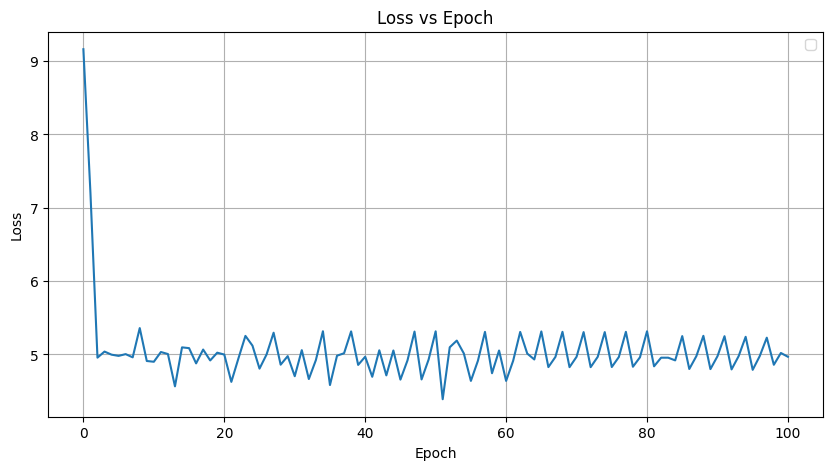

In [169]:
plt.figure(figsize=(10, 5))
print(epoch_losses)
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [176]:
def quantile_loss(y_pred, y_true, q=0.5):
    error = y_true - y_pred
    return torch.max((q - 1) * error, q * error).mean()
df = pd.read_csv("AXISBANK.csv")
# cols = ['Open', 'High', 'Low', 'Last']
cols = ['Open', 'High', 'Low', 'Prev Close', 'Last', 'VWAP']
target_col = 'Close'

k = 2   # Number of past steps
T = 2   # Number of future steps
q = 0.5  # Quantile for loss

# Convert to tensor
full_X = torch.tensor(df[cols].values, dtype=torch.float32)
full_y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(-1)
test_start = 18
test_end = 26
test_loss = 0.0
test_count = 0

with torch.no_grad():
    for i in range(test_start, test_end - (k + T) + 1):
        # window = full_features[i:i+k+T]
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]

        x_k = window[:k].unsqueeze(0)
        # x_T = window[k:k+T, 0].view(1, T, 1)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        loss = quantile_loss(y_pred, y_T, q=q)

        test_loss += loss.item()
        test_count += 1
       

avg_test_loss = test_loss / test_count if test_count > 0 else float('nan')
print(f"\nTest Loss (index {test_start} to {test_end}): {avg_test_loss:.4f}")
print(test_count)


Test Loss (index 18 to 26): 0.9856
5


In [177]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")

Trainable parameters: 190


[26.299999237060547, 25.950000762939453, 25.950000762939453, 24.799999237060547, 24.799999237060547, 25.0, 25.0, 23.200000762939453, 23.200000762939453, 24.0, 24.0, 23.600000381469727, 23.600000381469727, 23.25, 23.25, 25.149999618530273, 25.149999618530273, 24.899999618530273, 24.899999618530273, 25.600000381469727, 25.600000381469727, 24.450000762939453, 24.450000762939453, 25.100000381469727, 25.100000381469727, 24.799999237060547, 24.799999237060547, 25.049999237060547, 25.049999237060547, 27.049999237060547, 27.049999237060547, 29.25, 29.25, 31.600000381469727]
[26.238386154174805, 26.538455963134766, 26.538455963134766, 24.988126754760742, 24.988126754760742, 25.738277435302734, 25.738277435302734, 23.737911224365234, 23.737911224365234, 23.33785057067871, 23.33785057067871, 23.837928771972656, 23.837928771972656, 23.237836837768555, 23.237836837768555, 24.988126754760742, 24.988126754760742, 25.038135528564453, 25.038135528564453, 25.48822593688965, 25.48822593688965, 25.0381355

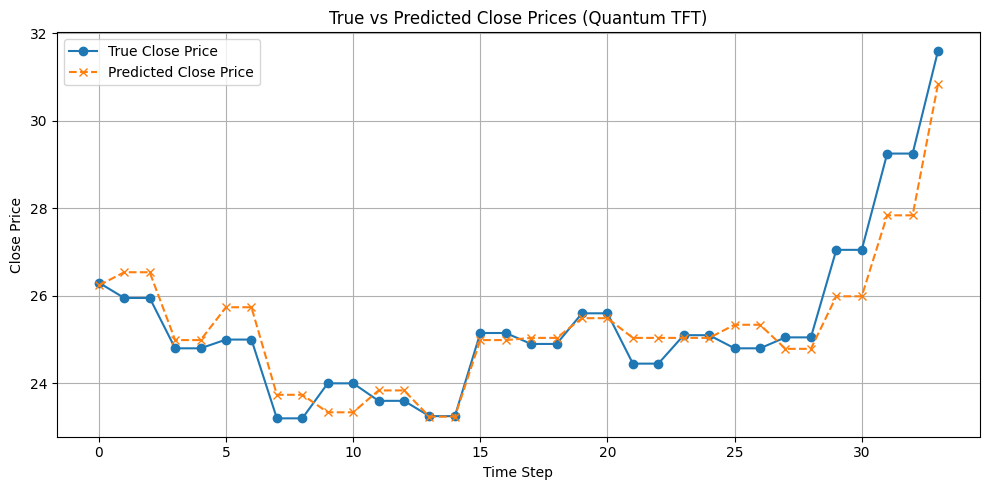

In [42]:
true_vals = []
pred_vals = []

with torch.no_grad():
    for i in range(20 - (k + T) + 1):
        window = full_X[i:i+k+T]
        window_y = full_y[i:i+k+T]

        x_k = window[:k].unsqueeze(0)
        # x_T = window[k:k+T, 0].view(1, T, 1)
        x_T = window[k:k+T].unsqueeze(0)
        y_T = window_y[k:k+T].unsqueeze(0)

        y_pred = model(x_k, x_T)
        
        true_vals.extend(y_T.squeeze().tolist())
        pred_vals.extend(y_pred.squeeze().tolist())
print(true_vals)
print(pred_vals)
# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(true_vals, label='True Close Price', marker='o')
plt.plot(pred_vals, label='Predicted Close Price', linestyle='--', marker='x')
plt.title('True vs Predicted Close Prices (Quantum TFT)')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

True values (Close): [34.150001525878906, 36.900001525878906]
Predicted values (Close): [34.15009689331055, 36.90007400512695]


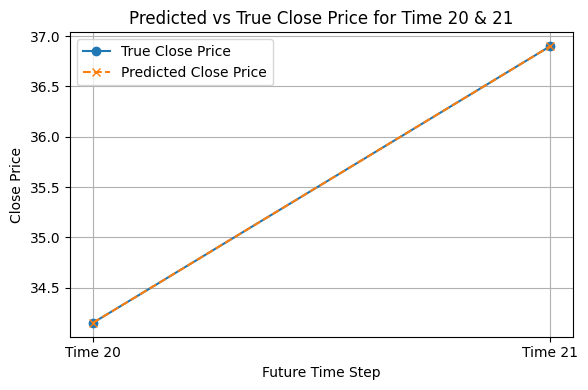

In [20]:
# Make prediction using rows 18-19 for input and predicting rows 20-21
k = 2
T = 2
start_index = 18

with torch.no_grad():
    window = full_X[start_index:start_index + k + T]
    window_y = full_y[start_index:start_index + k + T]

    x_k = window[:k].unsqueeze(0)  # shape: (1, k, num_features)
    # x_T = window[k:k+T, 0].view(1, T, 1)
    x_T = window[k:k+T].unsqueeze(0)  # shape: (1, T, num_features)
    y_T = window_y[k:k+T].unsqueeze(0)  # ground truth for future steps

    y_pred = model(x_k, x_T)  # model should already be on .double

    true_vals = y_T.squeeze().tolist()
    pred_vals = y_pred.squeeze().tolist()

# Print values
print("True values (Close):", true_vals)
print("Predicted values (Close):", pred_vals)

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.plot([0, 1], true_vals, label='True Close Price', marker='o')
plt.plot([0, 1], pred_vals, label='Predicted Close Price', linestyle='--', marker='x')
plt.xticks([0, 1], ['Time 20', 'Time 21'])
plt.title('Predicted vs True Close Price for Time 20 & 21')
plt.xlabel('Future Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[29.25, 31.600000381469727, 34.150001525878906, 36.900001525878906]
[33.69110870361328, 37.643218994140625]


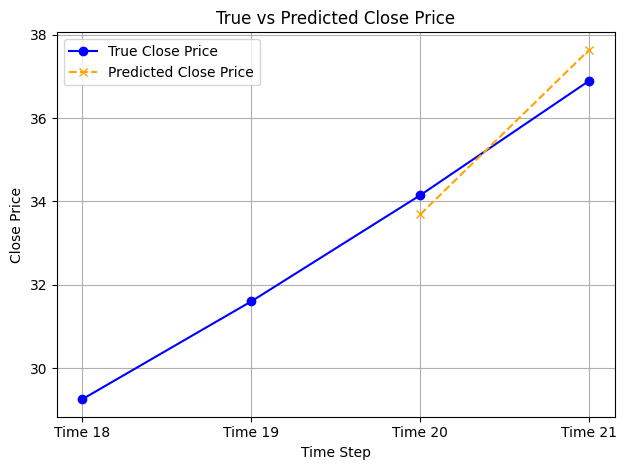

In [ ]:


# --- Set parameters ---
k = 2  # past steps
T = 2  # future steps
start_index = 18  # starting index

# --- Make prediction ---
with torch.no_grad():
    window = full_X[start_index : start_index + k + T]
    window_y = full_y[start_index : start_index + k + T]

    x_k = window[:k].unsqueeze(0)               # shape: (1, k, num_features)
    x_T = window[k:k+T].unsqueeze(0)            # shape: (1, T, num_features)
    y_T = window_y[k:k+T].unsqueeze(0)          # future ground truth

    y_pred = model(x_k, x_T)

    true_vals = window_y.squeeze().tolist()     # true values from t=18 to t=21
    pred_vals = y_pred.squeeze().tolist()       # predicted values for t=20 to t=21

print(true_vals)
print(pred_vals)

# --- Plot ---
time_true = list(range(start_index, start_index + k + T))        # [18, 19, 20, 21]
time_pred = list(range(start_index + k, start_index + k + T))    # [20, 21]

plt.plot(time_true, true_vals, label='True Close Price', marker='o', color='blue')
plt.plot(time_pred, pred_vals, label='Predicted Close Price', linestyle='--', marker='x', color='orange')

plt.xticks(time_true, [f'Time {t}' for t in time_true])
plt.title('True vs Predicted Close Price')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
